In [4]:
%matplotlib inline


迁移学习教程
========================== 

在这个教程里，我们会学习怎么使用迁移学习来训练模型。通常我们的训练数据量不会很大，很难达到像ImageNet那样上百万的标注
数据集。我们可以使用迁移学习来解决训练数据不足的问题。

迁移学习里，我们根据训练数据的多少通常可以采取如下方法：

- 如果训练数据很少，那么我们通常把一个pretraning的网络的大部分固定住，然后只是把最后一个全连接层换成新的(最后一层通常是不一样的，因为分类的数量不同)，然后只训练这一层

- 如果训练数据稍多一些，那么我们可以把pretraining的网络的前面一些层固定住，但后面的层不固定，把最后一层换新的，然后训练

- 如果训练数据更多一些，那么所有的pretraining的层都可以fine-tuning，只是用pretraining的参数作为初始化参数。


In [5]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

加载数据
---------

我们使用torchvision和torch.utils.data包来加载数据


我们要解决的问题是训练一个模型来区分**蚂蚁** and **蜜蜂**。每个类别我们大概有120个训练数据。
另外每个类有75个验证数据。这是一个很小的训练集，如果直接用一个神经网络来训练，效果会很差。现在我们用迁移
学习来解决这个问题。数据可以在[这里](https://download.pytorch.org/tutorial/hymenoptera_data.zip)下载。也可以在[这里](https://media.githubusercontent.com/media/fancyerii/fancyerii.github.io/master/assets/hymenoptera_data.zip)下载。
下载后请解压到data目录下。



In [6]:
# 训练的时候会做数据增强和归一化
# 而验证的时候只做归一化
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

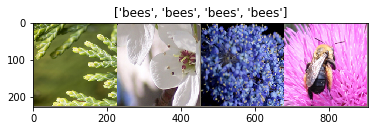

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


# 得到一个batch的数据
inputs, classes = next(iter(dataloaders['train']))

# 把batch张图片拼接成一个大图
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

训练模型
------------------

现在我们来实现一个用于训练模型的通用函数。这里我们会展示：

-  learning rate的自适应
-  保存最好的模型

在下面的函数中，参数``scheduler``是来自``torch.optim.lr_scheduler``的LR scheduler对象(_LRScheduler的子类）



In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每个epoch都分为训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # 训练阶段
            else:
                model.eval()   # 验证阶段

            running_loss = 0.0
            running_corrects = 0

            # 变量数据集
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 参数梯度清空
                optimizer.zero_grad()

                # forward
                # 只有训练的时候track用于梯度计算的历史信息。
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 如果是训练，那么需要backward和更新参数 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 保存验证集上的最佳模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 加载最优模型
    model.load_state_dict(best_model_wts)
    return model

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning模型
----------------------

加载一个预训练的模型，重置最后的全连接层，然后重新训练模型。




In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 所有的参数都可以训练
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每7个epoch learning rate变为原来的10% 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6778 Acc: 0.6598
val Loss: 0.2497 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.6869 Acc: 0.7295
val Loss: 0.6803 Acc: 0.8105

Epoch 2/24
----------
train Loss: 0.6460 Acc: 0.7623
val Loss: 0.3178 Acc: 0.8627

Epoch 3/24
----------
train Loss: 0.6041 Acc: 0.7213
val Loss: 0.4568 Acc: 0.8105

Epoch 4/24
----------
train Loss: 0.4706 Acc: 0.8074
val Loss: 0.4201 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.4898 Acc: 0.8197
val Loss: 0.3838 Acc: 0.8497

Epoch 6/24
----------
train Loss: 0.4372 Acc: 0.8156
val Loss: 0.4540 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.2777 Acc: 0.8770
val Loss: 0.3085 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.2322 Acc: 0.9057
val Loss: 0.2815 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.4153 Acc: 0.8156
val Loss: 0.3059 Acc: 0.8824

Epoch 10/24
----------
train Loss: 0.2533 Acc: 0.9016
val Loss: 0.2875 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.2689 Acc: 0.8975
val Loss: 0.2895 Acc: 0.8954

Ep

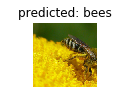

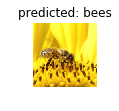

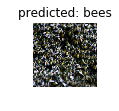

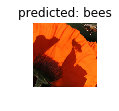

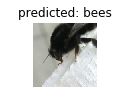

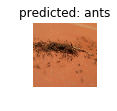

In [12]:
visualize_model(model_ft)

我们用可以固定住前面层的参数，只训练最后一层


In [13]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 新加的层默认requires_grad=True 
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 值训练最后一个全连接层。
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5602 Acc: 0.6967
val Loss: 0.4210 Acc: 0.8105

Epoch 1/24
----------
train Loss: 0.4979 Acc: 0.7418
val Loss: 0.2921 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.5891 Acc: 0.7254
val Loss: 0.2140 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4340 Acc: 0.7869
val Loss: 0.2246 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.3768 Acc: 0.8443
val Loss: 0.2333 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.7258 Acc: 0.6885
val Loss: 0.2524 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.5147 Acc: 0.8156
val Loss: 0.2195 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3560 Acc: 0.8443
val Loss: 0.2075 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3713 Acc: 0.8361
val Loss: 0.1981 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.2797 Acc: 0.8689
val Loss: 0.2184 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.4125 Acc: 0.8238
val Loss: 0.1972 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3408 Acc: 0.8525
val Loss: 0.1965 Acc: 0.9477

Ep

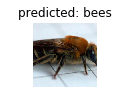

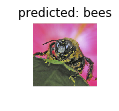

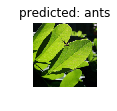

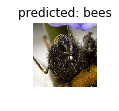

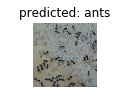

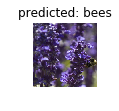

In [15]:
visualize_model(model_conv)

plt.ioff()
plt.show()